In [104]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# run for a significant amount of time steps
from run_gas_environment import make_env
from stable_baselines3 import A2C, DQN


# Environment Definition

An environment in reinforcement learning contains all the state dynamics that we want to model

In [105]:
# testing a new kind of environment - a simple gas container
# able to control the inflow valve
import gym
import numpy as np
from gym import  spaces
import numpy as np

def labeling_function(x):
    """
    simply returns 50 as the best value and -1 for 0 and 100
    :param x:
    :return:
    """
    CENTER = 0.5
    res = -1 + 2*(CENTER - np.abs(x-CENTER) ) / CENTER
    if x >= 0.45 and x <= 0.55:
        return 5
    else:
        return res

x = np.linspace(0, 1, 1000)
#plt.plot(x, labeling_function(x))

class SimpleGasEnvironment(gym.Env):
    metadata = {'render.modes': ['console']}

    # Constants to make code readable
    DOWN = 0
    NOTHING = 1
    UP = 2

    MIN_VALVE = 0.0
    MAX_VALVE = 1.0
    INIT_VALVE = 0.5
    DELTA_VALVE = 0.2
    DT = 0.01

    MIN_LINEPACK = 0.0
    MAX_LINEPACK = 1.0
    INIT_LINEPACK = 0.5

    def __init__(self, in_flow, out_flow, randomize=True):
        super(SimpleGasEnvironment, self).__init__()
        self.randomize = randomize
        # define action and observation space for gym.spaces
        self.action_space = spaces.Discrete(3) # represents a nudge up or down
        self.observation_space = spaces.Box(low=np.array([self.MIN_LINEPACK, self.MIN_VALVE]),
                                            high=np.array([self.MAX_LINEPACK, self.MAX_VALVE]), shape=(2,), dtype=np.float32)


        self.linepack = self.INIT_LINEPACK
        if randomize:
            self.linepack = np.clip(self.linepack + np.random.normal(0, 0.3), 0.0, 1.0)

        self.valve_position = self.INIT_VALVE
        if randomize:
            self.valve_position = np.clip(self.valve_position + np.random.normal(0, 0.3), 0.0, 1.0)

        # inflow is assumed to be constant and can be passed via constructor
        self.in_flow = in_flow

        # for now outflow is also constant, but this will be random function
        self.out_flow = out_flow

    def reset(self):
        """
        Important: the observation must be a numpy array
        :return: (np.array)
        """

        # "Linepack" refers to the volume of gas that can be "stored" in a gas pipeline.
        self.linepack = self.INIT_LINEPACK
        if self.randomize:
            self.linepack = np.clip(self.linepack + np.random.normal(0, 0.1), 0.0, 1.0)

        self.valve_position = self.INIT_VALVE
        if self.randomize:
            self.valve_position = np.clip(self.valve_position + np.random.normal(0, 0.1), 0.0, 1.0)

        # where am I will be a numpy array (1,) containing the position as float
        return np.array([self.linepack, self.valve_position]).astype(np.float32)

    def step(self, action):
        last_valve_position = self.valve_position
        #print("Action picked: ", action)
        if action == self.DOWN:
            self.valve_position -= self.DELTA_VALVE
        elif action == self.NOTHING:
            pass
        elif action == self.UP:
            self.valve_position += self.DELTA_VALVE
        else:
            raise ValueError(f"Received action {action} which is not part of the action space")

        self.valve_position = np.clip(self.valve_position, 0.0, 1.0)

        # the actual dynamics go right here
        last_linepack = self.linepack
        self.linepack = self.linepack + self.DT * (self.in_flow * self.valve_position - self.out_flow )

        done = bool(self.linepack < self.MIN_LINEPACK or self.linepack > self.MAX_LINEPACK)

        # reward is issued according
        reward = labeling_function(self.linepack)

        # an empty set of info
        info = {}
        #info["TimeLimit.truncated"] = True

        # use the temporal differences
        lp_dt = (self.linepack - last_linepack) / self.DT
        vp_dt = (self.valve_position - last_valve_position) / self.DT
        return np.array([self.linepack, self.valve_position]).astype(np.float32), reward, done, info

    def render(self, mode="console"):
        if mode != "console":
            raise NotImplementedError()
        # now just some pretty prints

        print("Line pack", self.linepack)

    def close(self):
        # nothing to do yet
        pass

def make_env():
    env = SimpleGasEnvironment(in_flow=0.4, out_flow=0.25)
    from stable_baselines3.common.env_checker import check_env

    # It will check your custom environment and output additional warnings if needed
    check_env(env)
    return env

env = make_env()

C:\Users\Schiendorfer\Anaconda3\envs\rl-playground\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


# Labeling function
The labeling function (in Qualicision-speak) refers to the valuation of a particular state. Here, we just use the linepack value to determine how well we're doing

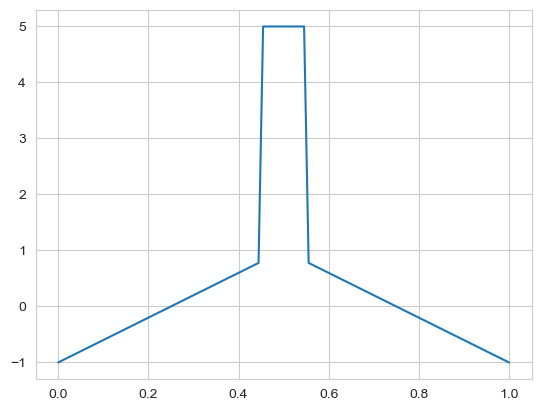

In [106]:
x = np.linspace(0, 1, 100)
rw = np.array([labeling_function(x_) for x_ in x])
plt.plot(x, rw)

# Policy evaluation utils
These are meant to run an environment with a static or learned policy

In [107]:
# some utils for running a policy
def model_wrapper(model):
    return lambda obs : model.predict(obs, deterministic=True)[0]

def evaluate_policy(policy, env=env):
    linepacks = []
    valve_positions = []
    actions = []
    rewards = []

    n_steps = 500
    obs = env.reset()

    for i in range(n_steps):
        act = policy(obs)
        obs, reward, done, info = env.step(act)
        linepacks.append(obs[0])
        valve_positions.append(env.valve_position)
        actions.append(act)
        rewards.append(reward)

        if done:
            print("Game over")
            break

    plt.figure(figsize=(12,8))
    plt.subplot(2, 2, 1) # 2 rows, 2 cols, 1st fig
    plt.plot(linepacks)
    plt.title("Linepacks")
    plt.subplot(2, 2, 2) # 2 rows, 2 cols, 2nd fig
    plt.plot(valve_positions)
    plt.title("Valve positions")
    plt.subplot(2, 2, 3) # 2 rows, 2 cols, 3rd fig
    plt.plot(actions)
    plt.title("Actions")
    plt.subplot(2, 2, 4) # 2 rows, 2 cols, 4th fig
    plt.title("Rewards")
    plt.plot(rewards)
    print("Achieved rewards:", np.sum(rewards))

In [108]:
def visualize_policy_lp(policy):
    line_pack_ranges = np.linspace(0, 1, 1000)
    actions = np.array([policy( np.array([lp, 0.5])) for lp in line_pack_ranges])
    plt.plot(line_pack_ranges, actions)
    plt.title("Policy")

In [109]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

def visualize_policy(policy):
    line_pack_ranges = np.linspace(0, 1, 10)
    valve_positions = np.linspace(0, 1, 10)

    actions = np.array([[policy( np.array([lp, vp])) for vp in valve_positions] for lp in line_pack_ranges])
    ax = sns.heatmap(actions, linewidth=0.5)
    # Manually specify colorbar labelling after it's been generated
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([0, 1, 2])
    colorbar.set_ticklabels([f'({SimpleGasEnvironment.DOWN}) DOWN',
                             f'({SimpleGasEnvironment.NOTHING}) NOTHING',
                             f'({SimpleGasEnvironment.UP}) UP'])

    ax.set(xlabel="Valve position",
           xticklabels=np.round(line_pack_ranges, 2),
           ylabel="Linepack",
           yticklabels=np.round(valve_positions, 2))
    plt.title("Policy")
    plt.show()


# Fixed policy control
For now, just implementing bang-bang control

In [110]:
def bang_bang_control(obs):
    if obs[0] < 0.5: # obs[0] contains the lineback
        return SimpleGasEnvironment.UP
    else:
        return SimpleGasEnvironment.DOWN


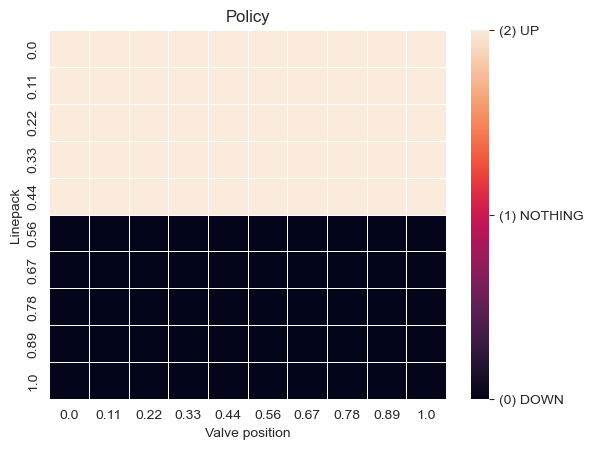

In [111]:
visualize_policy(bang_bang_control)

Achieved rewards: 2500


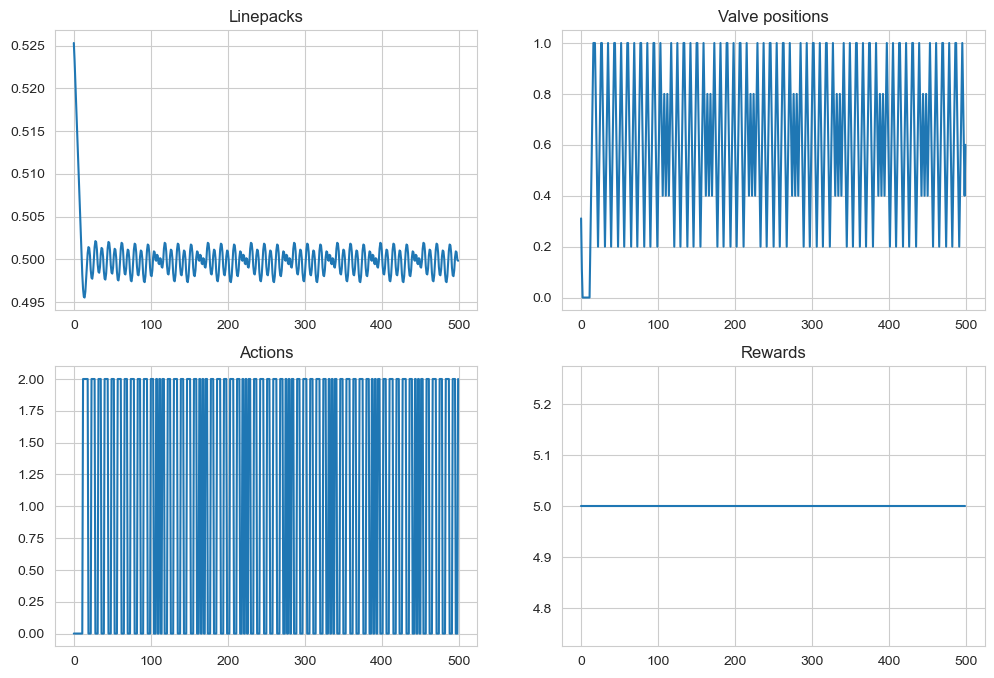

In [112]:
evaluate_policy(bang_bang_control)

# Training an RL-Agent
Really starting with something simple

In [118]:
from stable_baselines3 import A2C, DQN, PPO
import torch as th
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True

# Create log dir
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)

# env = make_env()
env = make_env()
env = Monitor(env, log_dir)
from stable_baselines3.ppo import MlpPolicy

# for normalize, look at https://stable-baselines.readthedocs.io/en/master/guide/examples.html
def train_stable_baselines(env):
    env.reset()
    print("Training ....")
    policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=[dict(pi=[8], vf=[8])])
    #model = A2C("MlpPolicy",env=env, verbose=0, policy_kwargs=policy_kwargs)
    # Create the callback: check every 1000 steps
    model = A2C(
        policy=MlpPolicy,
        env=env,
        #policy_kwargs=policy_kwargs,
        seed=10,
#        batch_size=64,
        #ent_coef=0.0,
        #gamma = 0.95,
        #learning_rate=0.001,
#        n_epochs=20,
        #n_steps=64,
    )
    callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

    #model = A2C("MlpPolicy",env=env, verbose=1)
    model.learn(total_timesteps=20_000, callback=callback)
    model.save(f"{type(model).__name__}_simple_gas_nb")
    return model

C:\Users\Schiendorfer\Anaconda3\envs\rl-playground\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [119]:
model = train_stable_baselines(env)

Training ....
Num timesteps: 2000
Best mean reward: -inf - Last mean reward per episode: 660.54
Saving new best model to log\best_model.zip
Num timesteps: 3000
Best mean reward: 660.54 - Last mean reward per episode: 465.66
Num timesteps: 4000
Best mean reward: 660.54 - Last mean reward per episode: 356.59
Num timesteps: 5000
Best mean reward: 660.54 - Last mean reward per episode: 318.70
Num timesteps: 6000
Best mean reward: 660.54 - Last mean reward per episode: 304.72
Num timesteps: 7000
Best mean reward: 660.54 - Last mean reward per episode: 306.02
Num timesteps: 8000
Best mean reward: 660.54 - Last mean reward per episode: 293.37
Num timesteps: 9000
Best mean reward: 660.54 - Last mean reward per episode: 245.65
Num timesteps: 10000
Best mean reward: 660.54 - Last mean reward per episode: 238.14
Num timesteps: 11000
Best mean reward: 660.54 - Last mean reward per episode: 203.73
Num timesteps: 12000
Best mean reward: 660.54 - Last mean reward per episode: 171.90
Num timesteps: 13

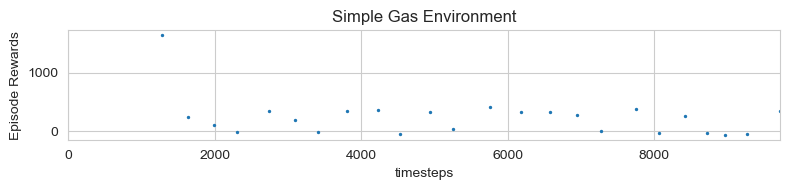

In [115]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "Simple Gas Environment")

Game over
Achieved rewards: -66.30323516862553


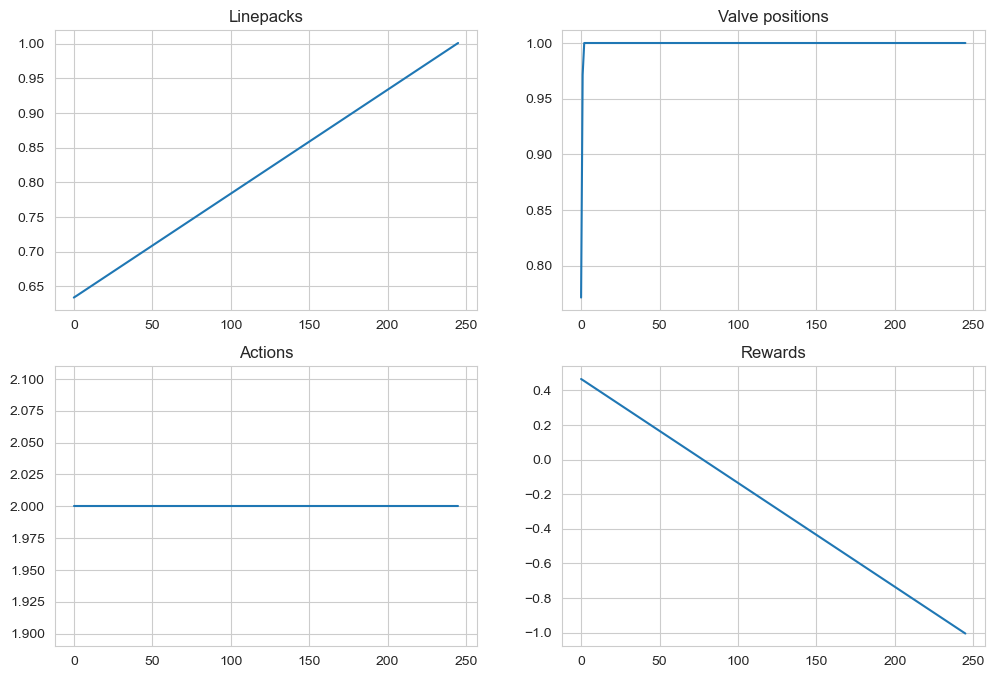

In [116]:
# retrieve best model first
model = None
model = A2C.load(os.path.join(log_dir, 'best_model.zip'))
evaluate_policy(model_wrapper(model))

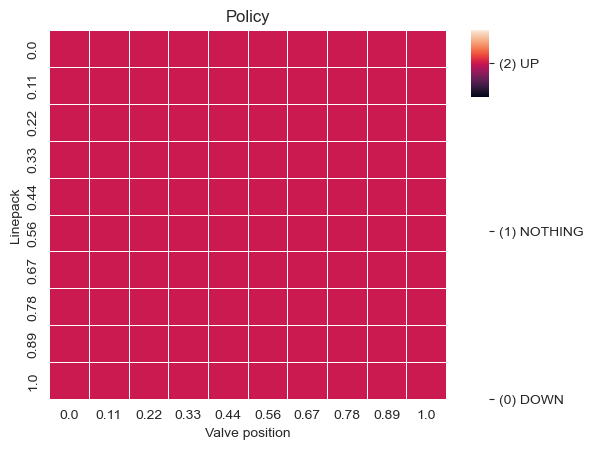

In [117]:
visualize_policy(model_wrapper(model))